In [ ]:
import os
import glob
import zipfile
from pathlib import Path

# Unzipping or extracting the .zip file

In [6]:
# The final destination folder 
target_folder = Path.home() / "Desktop" / "Sentinel_Data"

# 1. Find the .zip file
print(f"🔍 Searching for zip file in: {target_folder}")
try:
    # Use next() with glob to find the first match efficiently
    zip_path = next(target_folder.glob("*.zip"))
except StopIteration:
    print("Error: No .zip file found in the target folder.")
else:
    # 2. Define the extraction directory based on the zip file name (without extension)
    extraction_dir = target_folder / zip_path.stem
    extraction_dir.mkdir(parents=True, exist_ok=True)
    
    # 3. Perform the extraction
    print(f"Found zip file: {zip_path.name}")
    print(f"Extracting contents to: {extraction_dir}")
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_dir)
            
        print("✅ Success! File extracted.") 
        
    except Exception as e:
        print(f" An error occurred during extraction: {e}")

🔍 Searching for zip file in: C:\Users\admin\Desktop\Sentinel_Data
Found zip file: S2C_MSIL2A_20250221T050851_N0511_R019_T43PHQ_20250221T120413.zip
Extracting contents to: C:\Users\admin\Desktop\Sentinel_Data\S2C_MSIL2A_20250221T050851_N0511_R019_T43PHQ_20250221T120413
✅ Success! File extracted.


# Select and save required bands for processing in another folder

In [8]:
import shutil
from pathlib import Path

In [9]:
# 1. Define the main directory where the .SAFE folder is located 
#(.SAFE is associated with Earth Observation Data (EO Data) products)
base_dir = Path.home() / "Desktop" / "Sentinel_Data"

# 2. Define the output folder for the extracted bands
output_dir = Path.home() / "Desktop" / "Sentinel_Bands_Extracted"
output_dir.mkdir(parents=True, exist_ok=True)

# Define the desired resolution and band numbers
bands_to_find = [
    "B02_10m", # Blue
    "B03_10m", # Green
    "B04_10m", # Red
    "B08_10m", # Near-Infrared (NIR)
]

print(f" Starting search for bands in {base_dir}...")
print(f" Output directory: {output_dir}")

# 3. Find the .SAFE folder ---
try:
    # Use rglob to search recursively for the folder ending in .SAFE
    safe_folder = next(base_dir.rglob("*.SAFE"))
    print(f"✅ Found SAFE Product: {safe_folder.name}")
except StopIteration:
    print("ERROR: Could not find the .SAFE folder. Please check if the file was correctly unzipped.")
    exit()

# --- Search and Copy Bands ---
bands_found_count = 0
granule_dir = safe_folder / "GRANULE" 

if not granule_dir.exists():
    print(f" ERROR: GRANULE directory not found inside {safe_folder.name}.")
    exit()

# 4. Search the entire granule structure recursively
for band_id in bands_to_find:
    
    search_pattern = f"*{band_id}.jp2" 
    
    for src_path in granule_dir.rglob(search_pattern):
        
        tile_id = src_path.parts[-3].split('_')[-1] 
        new_filename = f"{tile_id}_{band_id}.jp2"
        dest_path = output_dir / new_filename
        
        #  Use shutil.copyfile for a content-only copy
        try:
            shutil.copyfile(src_path, dest_path)
            bands_found_count += 1
            print(f" [COPIED] {band_id} -> {dest_path.name}")
        except Exception as e:
            print(f" [FAIL] Could not copy {band_id}: {e}")
            
print(f"✅ Successfully copied {bands_found_count} bands to {output_dir}")

 Starting search for bands in C:\Users\admin\Desktop\Sentinel_Data...
 Output directory: C:\Users\admin\Desktop\Sentinel_Bands_Extracted
✅ Found SAFE Product: S2C_MSIL2A_20250221T050851_N0511_R019_T43PHQ_20250221T120413.SAFE
 [COPIED] B02_10m -> DATA_B02_10m.jp2
 [COPIED] B03_10m -> DATA_B03_10m.jp2
 [COPIED] B04_10m -> DATA_B04_10m.jp2
 [COPIED] B08_10m -> DATA_B08_10m.jp2
✅ Successfully copied 4 bands to C:\Users\admin\Desktop\Sentinel_Bands_Extracted


# Generating Normalized Difference Vegetation Index (NDVI), saving it as geotiff file

In [11]:
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# 1. Define the directory where the Sentinel bands are stored
Sentinel_dir = Path.home() / "Desktop" / "Sentinel_Bands_Extracted"

# List all files that end with the correct Sentinel-2 B04 (Red) and B08 (NIR) JP2 extensions
band4_files = glob.glob(os.path.join(Sentinel_dir, '*_B04_10m.jp2'))
band8_files = glob.glob(os.path.join(Sentinel_dir, '*_B08_10m.jp2'))

# Check if files are found for B04 and B08
if not band4_files or not band8_files:
    print("Error: Red (B04) or NIR (B08) band files not found in the directory.")
else:
    # Open the first file found for each band
    band4_path = band4_files[0]  # Red band (B04)
    band8_path = band8_files[0]  # NIR band (B08)

    # Load the bands as separate 1-band rasters
    band4 = rasterio.open(band4_path) # B04 (Red)
    band8 = rasterio.open(band8_path) # B08 (NIR)

    # Output the paths for verification
    print(f"Red band (B04) file path: {band4_path}")
    print(f"NIR band (B08) file path: {band8_path}")
    
    # Get the data from both bands as arrays (in float64 format for NDVI calculation)
    red = band4.read(1).astype('float64')
    nir = band8.read(1).astype('float64')

    # NDVI calculation: NDVI = (NIR - Red) / (NIR + Red)
    ndvi = np.where(
      (nir + red) == 0.,
       0,  # If NIR + Red is zero, set NDVI to zero
      (nir - red) / (nir + red)  # Standard NDVI formula
    )

  
 # -----------------------------------------------------------
# 2.  Export Geotiff
# -----------------------------------------------------------
    
#  Define the output path
output_filename = "NDVI_Result.tif"
output_path = Sentinel_dir / output_filename
    
#  Export NDVI image as GeoTIFF
with rasterio.open(
    output_path, 'w', driver='GTiff',
    width=band4.width,
    height=band4.height,
    count=1, crs=band4.crs,
    transform=band4.transform,
    dtype='float64',
    nodata=0
) as ndviImage:
    ndviImage.write(ndvi, 1)

print(f"NDVI image saved to: {output_path}")


Red band (B04) file path: C:\Users\admin\Desktop\Sentinel_Bands_Extracted\DATA_B04_10m.jp2
NIR band (B08) file path: C:\Users\admin\Desktop\Sentinel_Bands_Extracted\DATA_B08_10m.jp2
NDVI image saved to: C:\Users\admin\Desktop\Sentinel_Bands_Extracted\NDVI_Result.tif


#  plotting the NDVI image with legend scale

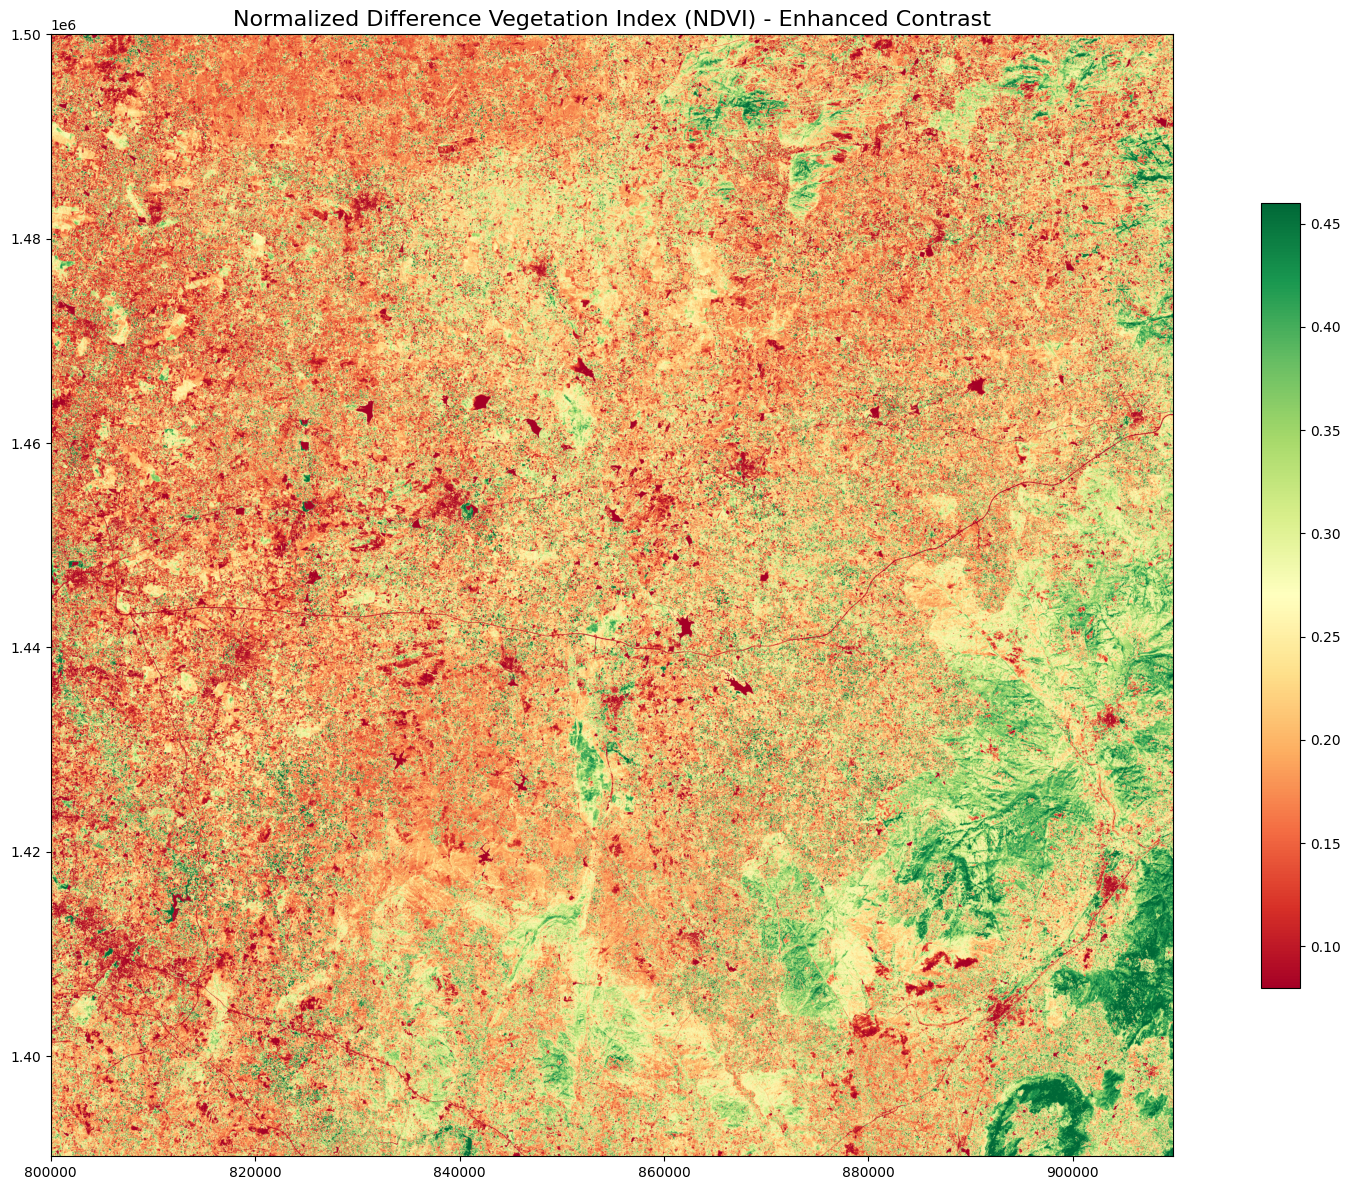

In [13]:
# -----------------------------------------------------------
# 1. PLOTTING THE NDVI IMAGE
# -----------------------------------------------------------
    
# Open the newly saved file for plotting
ndvi_read = rasterio.open(output_path)
ndvi_data = ndvi_read.read(1) # Read the single band data

# Calculate the actual min and max values for display
valid_ndvi = ndvi_data[ndvi_data > 0] 

if valid_ndvi.size > 0:
    min_ndvi = np.percentile(valid_ndvi, 2)
    max_ndvi = np.percentile(valid_ndvi, 98)
else:
    min_ndvi = 0.0
    max_ndvi = 0.8 

# Create the figure and plot with Vmin/Vmax limits
fig, ax = plt.subplots(figsize=(18, 12))

ax.set_title('Normalized Difference Vegetation Index (NDVI) - Enhanced Contrast', fontsize=16)

# Display the NDVI image using the calculated Vmin/Vmax for vivid contrast
plot.show(
    ndvi_read, 
    ax=ax, 
    cmap='RdYlGn', 
    vmin=min_ndvi,
    vmax=max_ndvi,
)

# Add a color bar to clearly show the stretched scale
fig.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.7)

#Adjust layout
fig.tight_layout()
#plt.show() 